# Load Dataset

https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data

In [1]:
from tensorflow.keras import utils

import tensorflow as tf



# Path ke dataset

data_dir = "/kaggle/input/bonebreakdl/Bone Break Classification - Copy"



# Load training data

train_data = utils.image_dataset_from_directory(

    data_dir,

    labels="inferred",

    label_mode="int",

    validation_split=0.1,

    subset="training",

    shuffle=True,

    color_mode="rgb",

    image_size=(299, 299),

    batch_size=64,

    seed=40,

)



# Load validation data

data_valid = utils.image_dataset_from_directory(

    data_dir,

    labels="inferred",

    label_mode="int",

    validation_split=0.1,

    subset="validation",

    shuffle=True,

    color_mode="rgb",

    image_size=(299, 299),

    batch_size=64,

    seed=40,

)



# Verifikasi dataset

class_names = train_data.class_names

print("Classes:", class_names)



# Menampilkan beberapa batch data

for images, labels in train_data.take(1):

    print("Shape of image batch:", images.shape)

    print("Shape of label batch:", labels.shape)

Found 1610 files belonging to 10 classes.
Using 1449 files for training.
Found 1610 files belonging to 10 classes.
Using 161 files for validation.
Classes: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Shape of image batch: (64, 299, 299, 3)
Shape of label batch: (64,)


# Preprocessing Data

In [2]:
# Normalisasi data

def normalize(image, label):

  return image/255.0, label



train_data = train_data.map(normalize)

data_valid= data_valid.map(normalize)

In [3]:
for img, label in train_data.take(1):

  print(type(img),type(label))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [4]:
train_x=[]

train_y=[]

for image,label in train_data:

   train_x.append(image)

   train_y.append(label)

train_x = tf.concat(train_x, axis=0)

train_y = tf.concat(train_y, axis=0)

In [5]:
val_x=[]

val_y=[]

for image,label in train_data:

   val_x.append(image)

   val_y.append(label)

val_x = tf.concat(val_x, axis=0)

val_y = tf.concat(val_y, axis=0)

In [6]:
#one hot encode

num_classes = 10

train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)

val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

# Plot Dataset

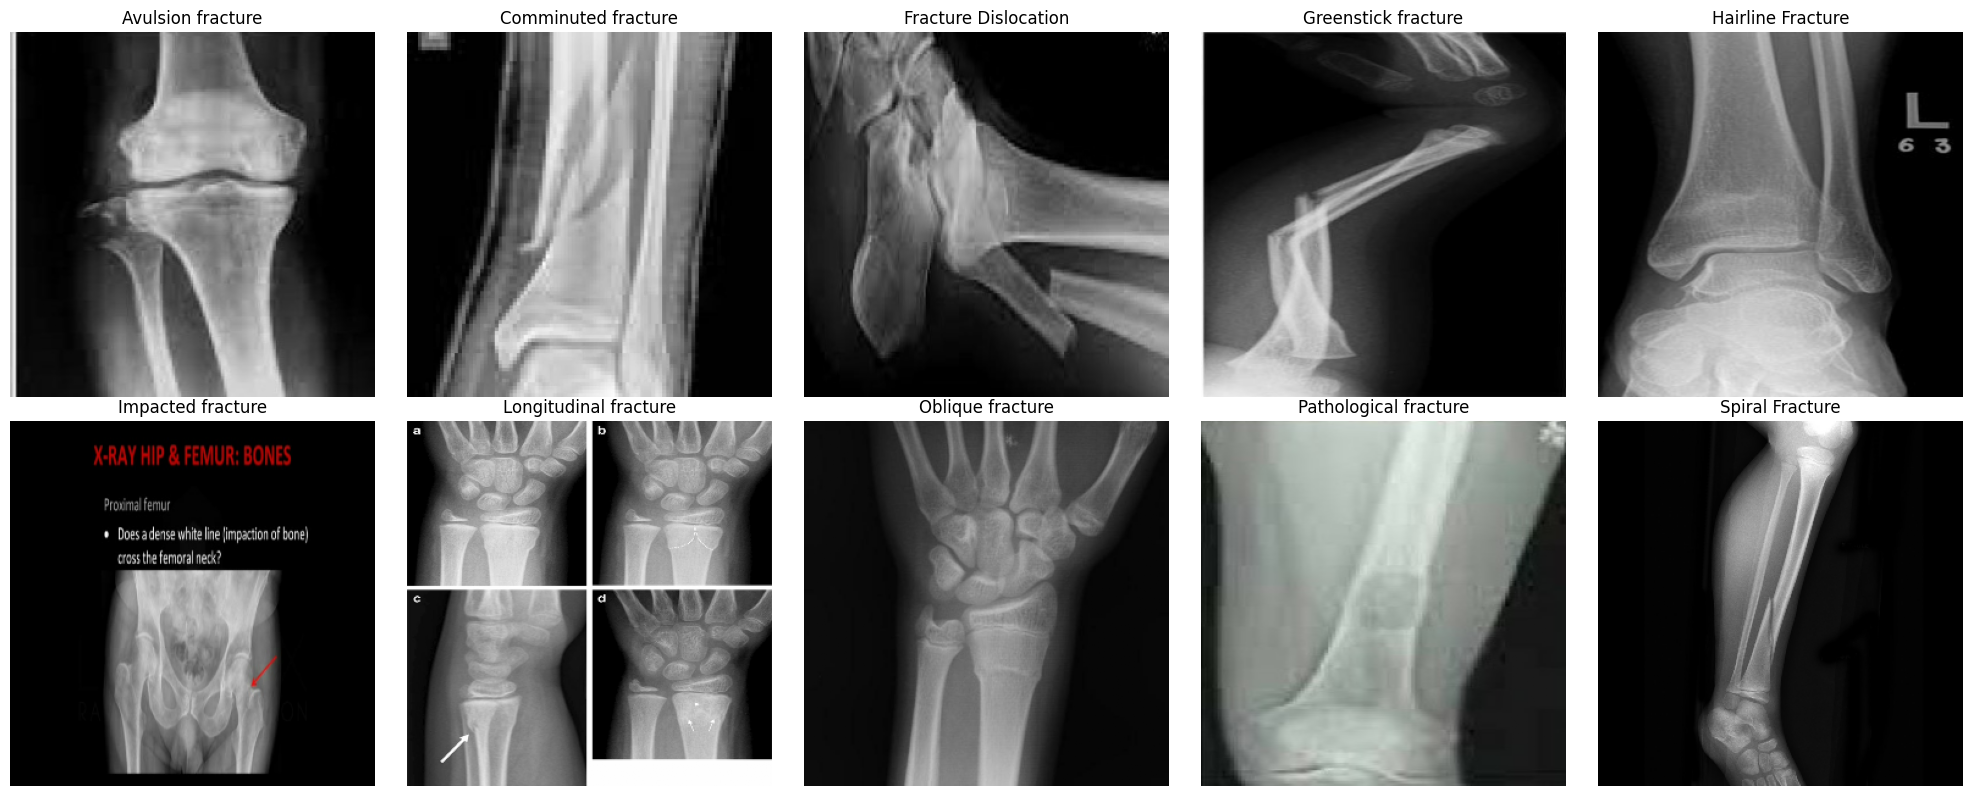

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_labels = [
    "Avulsion fracture", "Comminuted fracture", "Fracture Dislocation", "Greenstick fracture",
    "Hairline Fracture", "Impacted fracture", "Longitudinal fracture", "Oblique fracture",
    "Pathological fracture", "Spiral Fracture"
]

# Create the figure and axes
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Loop untuk setiap kelas
for idx, (ax, kelas) in enumerate(zip(axes.flat, range(len(class_labels)))):
    # Pilih gambar dari kelas yang dipilih
    gambar_kelas = train_x[train_y[:, kelas] == 1]
    
    # Plotkan gambar pertama dari kelas yang dipilih
    ax.imshow(gambar_kelas[0], cmap='gray')
    ax.set_title(class_labels[kelas])
    ax.axis('off')
    
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Model InceptionV3

In [8]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Input



# Define the input shape

input_shape = (299, 299, 3)



# Build the InceptionV3 model with data augmentation and learning rate scheduling

def build_inceptionv3(input_shape=(299, 299, 3), num_classes=10):

    # Define the input layer

    inputs = Input(shape=input_shape)



    # Load InceptionV3 model with pre-trained weights from ImageNet

    base_model = InceptionV3(input_shape=input_shape,

                             include_top=False,  # Exclude the top (fully connected) layers

                             weights='imagenet')(inputs)



    # Freeze the layers of the pre-trained model

    base_model.trainable = False



    # Create the custom model on top of the pre-trained base model

    x = layers.GlobalAveragePooling2D()(base_model)  # Global average pooling layer

    x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer

    x = layers.Dropout(0.5)(x)  # Dropout for regularization

    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation



    # Create the final model

    model = models.Model(inputs, outputs)



    # Compile the model with reduced learning rate

    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer,

                  loss='categorical_crossentropy',

                  metrics=['accuracy'])



    return model



# Add data augmentation and learning rate scheduler

datagen = ImageDataGenerator(

    rotation_range=30,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'

)



# Learning rate scheduler function

def scheduler(epoch, lr):

    if epoch > 15:

        return lr * 0.1  # Reduce learning rate by a factor of 10 after 10 epochs

    return lr



lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



# Build the model

model = build_inceptionv3(input_shape=input_shape, num_classes=10)



# Fit the model with data augmentation and callbacks, set epochs to 15

history = model.fit(datagen.flow(train_x, train_y, batch_size=64),

                    epochs=40,

                    validation_data=(val_x, val_y),

                    callbacks=[early_stopping, lr_scheduler])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733997519.272653      97 service.cc:145] XLA service 0x7bd078001da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733997519.272709      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733997519.272713      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733997586.078955      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.1313 - loss: 2.3711 - val_accuracy: 0.2409 - val_loss: 2.1506 - learning_rate: 1.0000e-04
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2861 - loss: 2.0394 - val_accuracy: 0.3244 - val_loss: 1.9792 - learning_rate: 1.0000e-04
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3719 - loss: 1.7854 - val_accuracy: 0.4320 - val_loss: 1.6620 - learning_rate: 1.0000e-04
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4672 - loss: 1.5294 - val_accuracy: 0.5135 - val_loss: 1.4552 - learning_rate: 1.0000e-04
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5575 - loss: 1.2718 - val_accuracy: 0.5749 - val_loss: 1.2648 - learning_rate: 1.0000e-04
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6792 - loss: 0.9977 - val_accuracy: 0.6922 - val_loss: 0.9417 - learning_rate: 1.0000e-04
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7346 - loss: 0.8392 - 

In [9]:
jumlah_variasi = len(datagen.flow(train_x, train_y, batch_size=64))
print(jumlah_variasi)

23


- Jumlah data awal: 1449 file- 
Jumlah variasi per gambar: 23
- 
Total data yang ter-augmentasi: 1449 x 23 = 33.327 file

# Evaluasi Model

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9727 - loss: 0.0719
Validation Loss: 0.08238796889781952, Validation Accuracy: 0.9689440727233887


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,664,768 (273.38 MB)

 Trainable params: 23,876,778 (91.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 47,753,558 (182.17 MB)

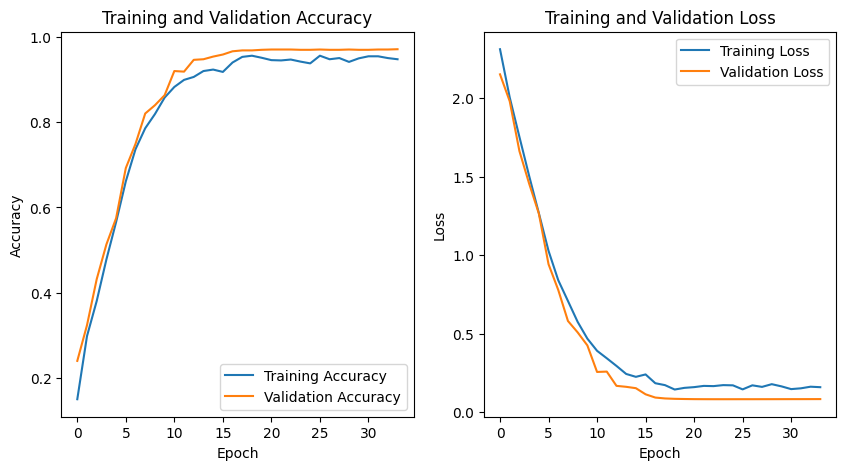

In [10]:
# Evaluasi model

loss, accuracy = model.evaluate(val_x, val_y)

print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')



model.summary()





# Plot the accuracy and validation loss

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend()

plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.title('Training and Validation Loss')



plt.show()

# Plot Hasil Prediksi vs Aktual

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step


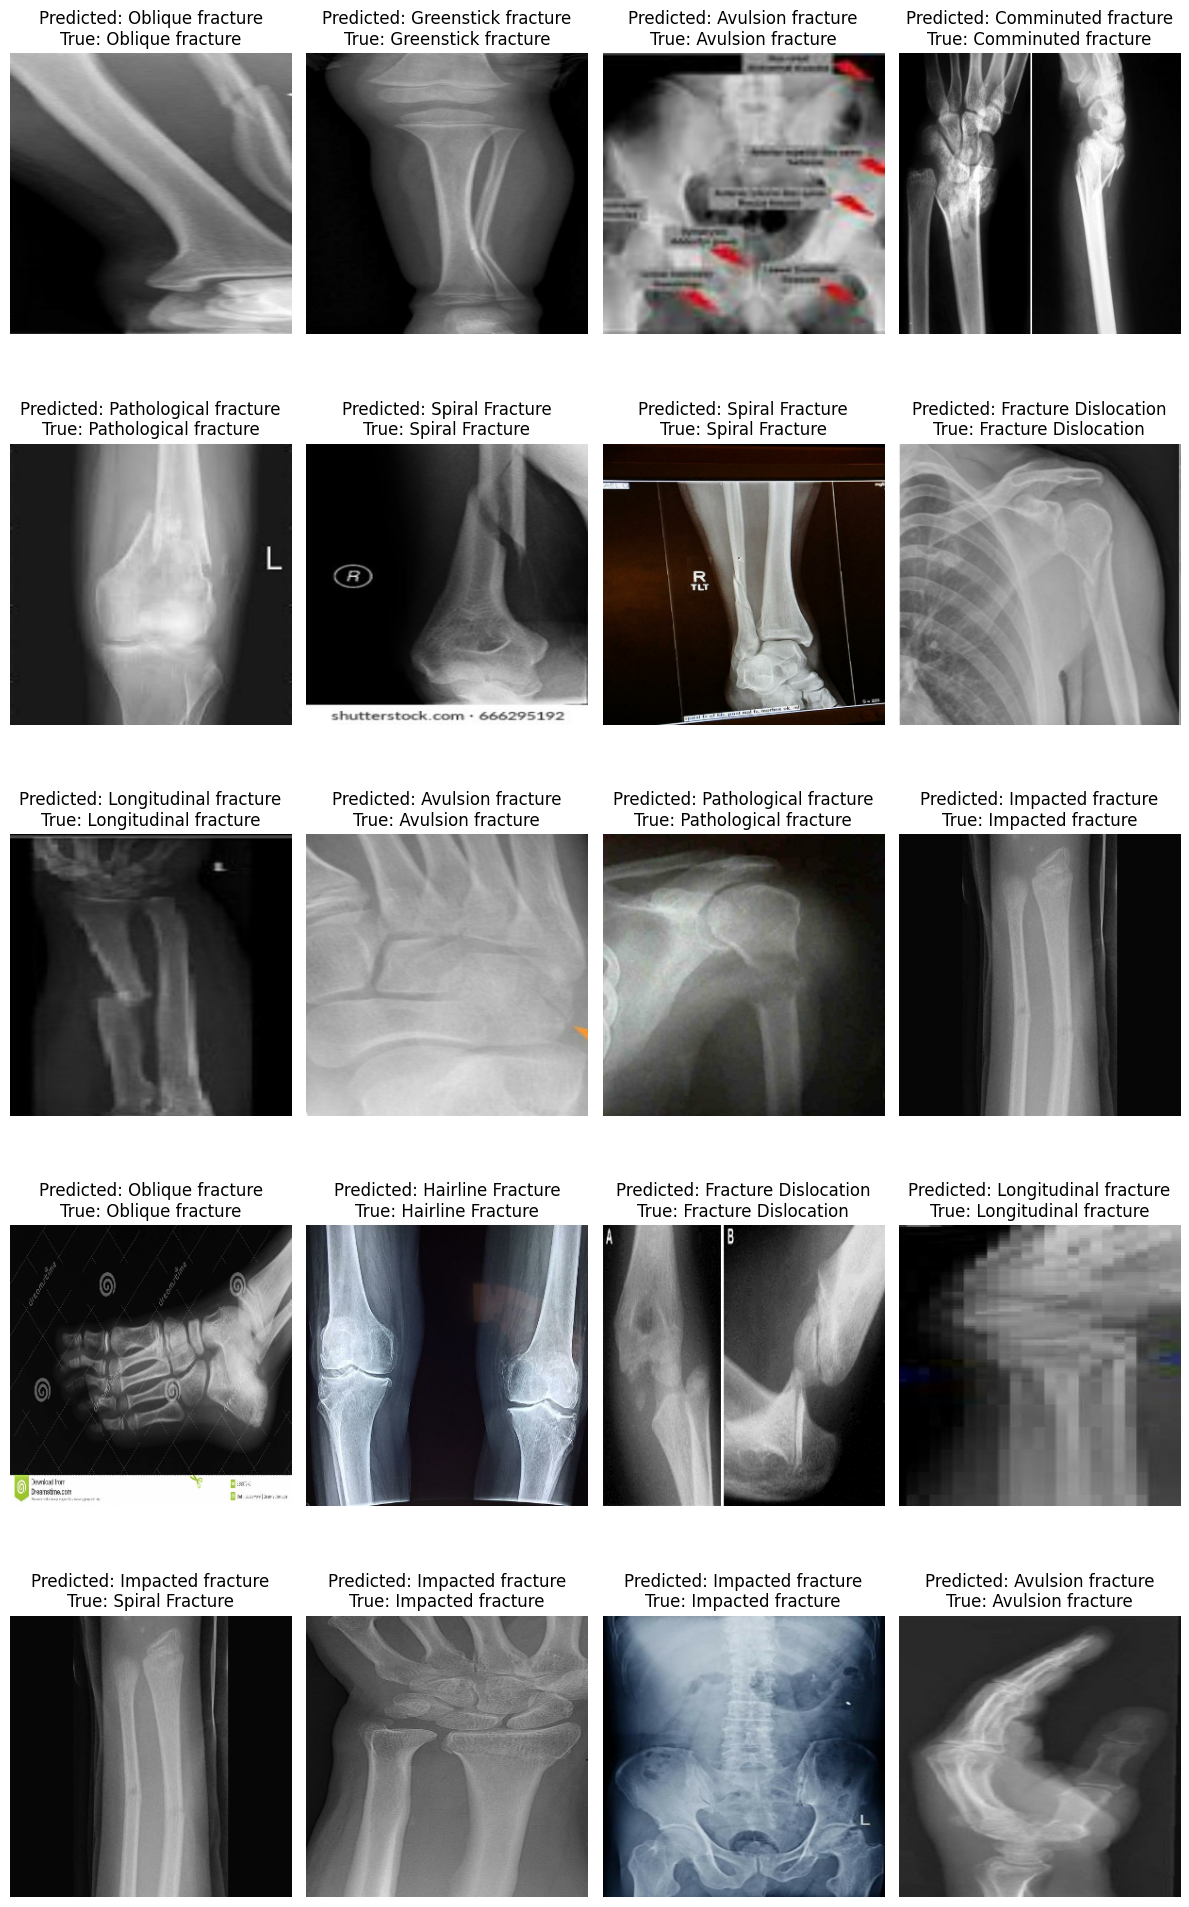

In [17]:
# Make predictions on the validation set

predictions = model.predict(val_x)



# Get the predicted class labels

predicted_labels = np.argmax(predictions, axis=1)



# Get the true class labels

true_labels = np.argmax(val_y, axis=1)



# Initialize the figure and subplots

fig, axes = plt.subplots(5, 4, figsize=(12, 20))



# Iterate through the first 10 images

for i, ax in enumerate(axes.flat):

    # Select the image, predicted label, and true label

    image, predicted_label, true_label = val_x[i], predicted_labels[i], true_labels[i]



    # Display the image

    ax.imshow(image)



    # Set the title with the predicted and true labels

    ax.set_title(f"Predicted: {class_labels[predicted_label]}\nTrue: {class_labels[true_label]}")

    ax.axis('off')



# Display the figure

plt.tight_layout() # Adjust layout to prevent overlapping titles

plt.show()

# Evaluation report

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
Classification Report:
                       precision    recall  f1-score   support

    Avulsion fracture       0.99      0.98      0.98       167
  Comminuted fracture       0.97      0.98      0.98       143
 Fracture Dislocation       0.99      0.99      0.99       208
  Greenstick fracture       0.99      0.99      0.99       119
    Hairline Fracture       1.00      0.96      0.98       156
    Impacted fracture       0.88      0.95      0.91       147
Longitudinal fracture       0.94      0.94      0.94       124
     Oblique fracture       1.00      0.97      0.98        88
Pathological fracture       1.00      1.00      1.00       166
      Spiral Fracture       0.95      0.92      0.93       131

             accuracy                           0.97      1449
            macro avg       0.97      0.97      0.97      1449
         weighted avg       0.97      0.97      0.97      1449



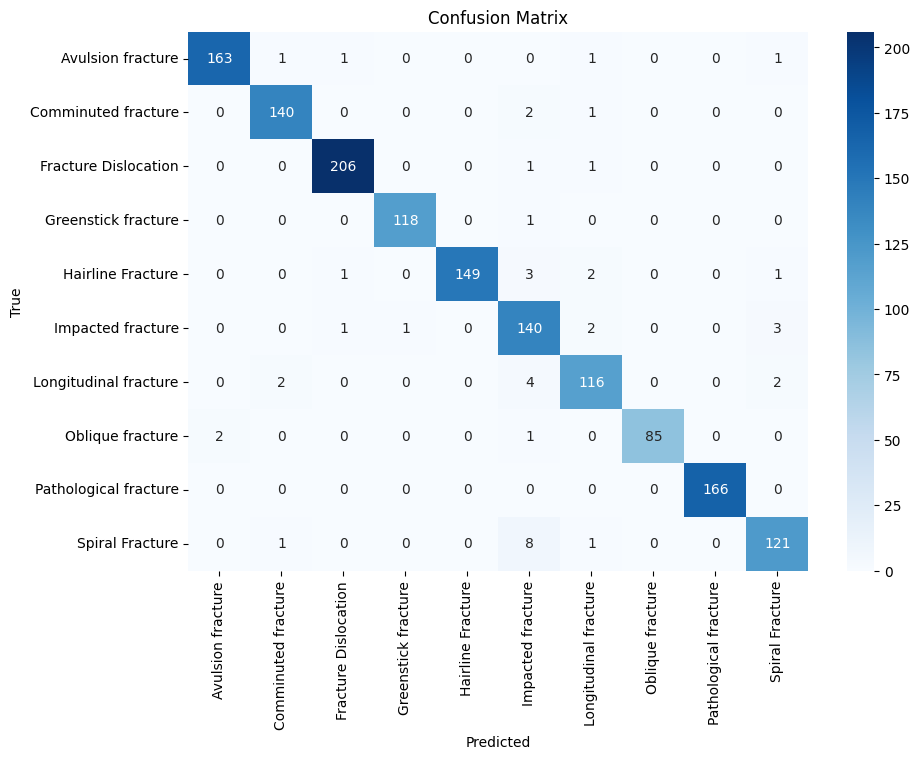

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np





# Example class names (replace with your actual class names)

class_names = ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",

              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",

              "Pathological fracture","Spiral Fracture"]



# Predict on the validation set

y_pred = model.predict(val_x)

y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices



# Convert true labels to class indices

y_true = np.argmax(val_y, axis=1)



# Print the classification report

print("Classification Report:")

print(classification_report(y_true, y_pred_classes, target_names=class_names))



# Confusion Matrix

conf_matrix = confusion_matrix(y_true, y_pred_classes)



# Plot the confusion matrix

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.title('Confusion Matrix')

plt.show()

# Coba Prediksi dengan data baru

https://www.kaggle.com/datasets/shyamgupta196/bone-fracture-split-classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Class: Pathological fracture
Prediction Confidence: 0.9972


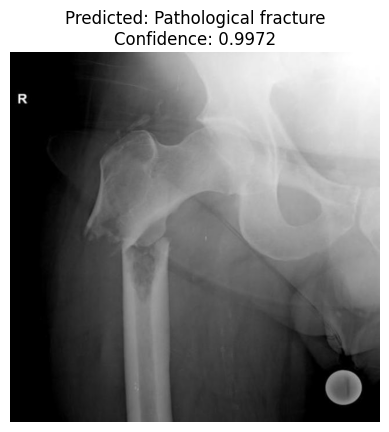

In [21]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

import numpy as np



# Fungsi untuk memuat gambar dan melakukan preprocessing

def load_and_preprocess_image(img_path, target_size=(299, 299)):

    # Muat gambar

    img = image.load_img(img_path, target_size=target_size)



    # Konversi gambar menjadi array numpy

    img_array = image.img_to_array(img)



    # Tambahkan dimensi batch (karena model menerima input dengan batch size)

    img_array = np.expand_dims(img_array, axis=0)



    # Normalisasi gambar agar sesuai dengan yang digunakan saat pelatihan

    img_array /= 255.0



    return img_array



# Tentukan path gambar baru yang ingin diuji

img_path = "/kaggle/input/testdl/test/Pathological fracture/5b15c2accb90c7880e90b2ca70ec9e28_jpg.rf.1eedf24749b4cb2037bfae26f918f7e8.jpg"



# Preprocessing gambar

img_array = load_and_preprocess_image(img_path)



# Prediksi menggunakan model

predictions = model.predict(img_array)



# Mendapatkan kelas yang diprediksi (indeks kelas)

predicted_class = np.argmax(predictions, axis=1)



# Nama kelas

class_names = ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",

              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",

              "Pathological fracture","Spiral Fracture"]



# Menampilkan hasil prediksi

print(f'Predicted Class: {class_names[predicted_class[0]]}')

print(f'Prediction Confidence: {predictions[0][predicted_class[0]]:.4f}')



# Menampilkan gambar yang diuji

img = image.load_img(img_path)

plt.imshow(img)

plt.axis('off')  # Menyembunyikan axis

plt.title(f'Predicted: {class_names[predicted_class[0]]}\nConfidence: {predictions[0][predicted_class[0]]:.4f}')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: Oblique fracture
Prediction Confidence: 0.9854


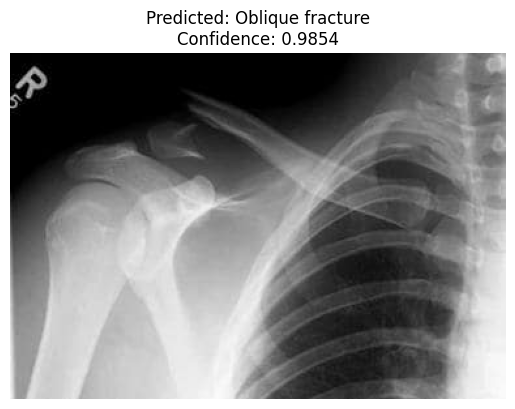

In [22]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

import numpy as np



# Fungsi untuk memuat gambar dan melakukan preprocessing

def load_and_preprocess_image(img_path, target_size=(299, 299)):

    # Muat gambar

    img = image.load_img(img_path, target_size=target_size)



    # Konversi gambar menjadi array numpy

    img_array = image.img_to_array(img)



    # Tambahkan dimensi batch (karena model menerima input dengan batch size)

    img_array = np.expand_dims(img_array, axis=0)



    # Normalisasi gambar agar sesuai dengan yang digunakan saat pelatihan

    img_array /= 255.0



    return img_array



# Tentukan path gambar baru yang ingin diuji

img_path = "/kaggle/input/testdl/test/Oblique fracture/43390tn.jpg"

# Preprocessing gambar

img_array = load_and_preprocess_image(img_path)



# Prediksi menggunakan model

predictions = model.predict(img_array)



# Mendapatkan kelas yang diprediksi (indeks kelas)

predicted_class = np.argmax(predictions, axis=1)



# Nama kelas

class_names = ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",

              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",

              "Pathological fracture","Spiral Fracture"]



# Menampilkan hasil prediksi

print(f'Predicted Class: {class_names[predicted_class[0]]}')

print(f'Prediction Confidence: {predictions[0][predicted_class[0]]:.4f}')



# Menampilkan gambar yang diuji

img = image.load_img(img_path)

plt.imshow(img)

plt.axis('off')  # Menyembunyikan axis

plt.title(f'Predicted: {class_names[predicted_class[0]]}\nConfidence: {predictions[0][predicted_class[0]]:.4f}')

plt.show()

Untuk hasil uji pakai data baru dengan 1 per 1 gambar model masih bisa untuk memprediksi dengan tepat

# Prediksi dengan data baru dalam jumlah besar

https://www.kaggle.com/datasets/shyamgupta196/bone-fracture-split-classification

Accuracy: 72.35%

Classification Report:
                       precision    recall  f1-score   support

    Avulsion fracture       0.78      0.84      0.81        56
  Comminuted fracture       0.87      0.76      0.81        79
 Fracture Dislocation       0.74      0.87      0.80        67
  Greenstick fracture       0.78      0.61      0.69        57
    Hairline Fracture       0.79      0.73      0.76        52
    Impacted fracture       0.43      0.60      0.50        58
Longitudinal fracture       0.59      0.67      0.63        49
     Oblique fracture       0.86      0.59      0.70        54
Pathological fracture       0.89      0.85      0.87        55
      Spiral Fracture       0.67      0.66      0.67        59

             accuracy                           0.72       586
            macro avg       0.74      0.72      0.72       586
         weighted avg       0.75      0.72      0.73       586



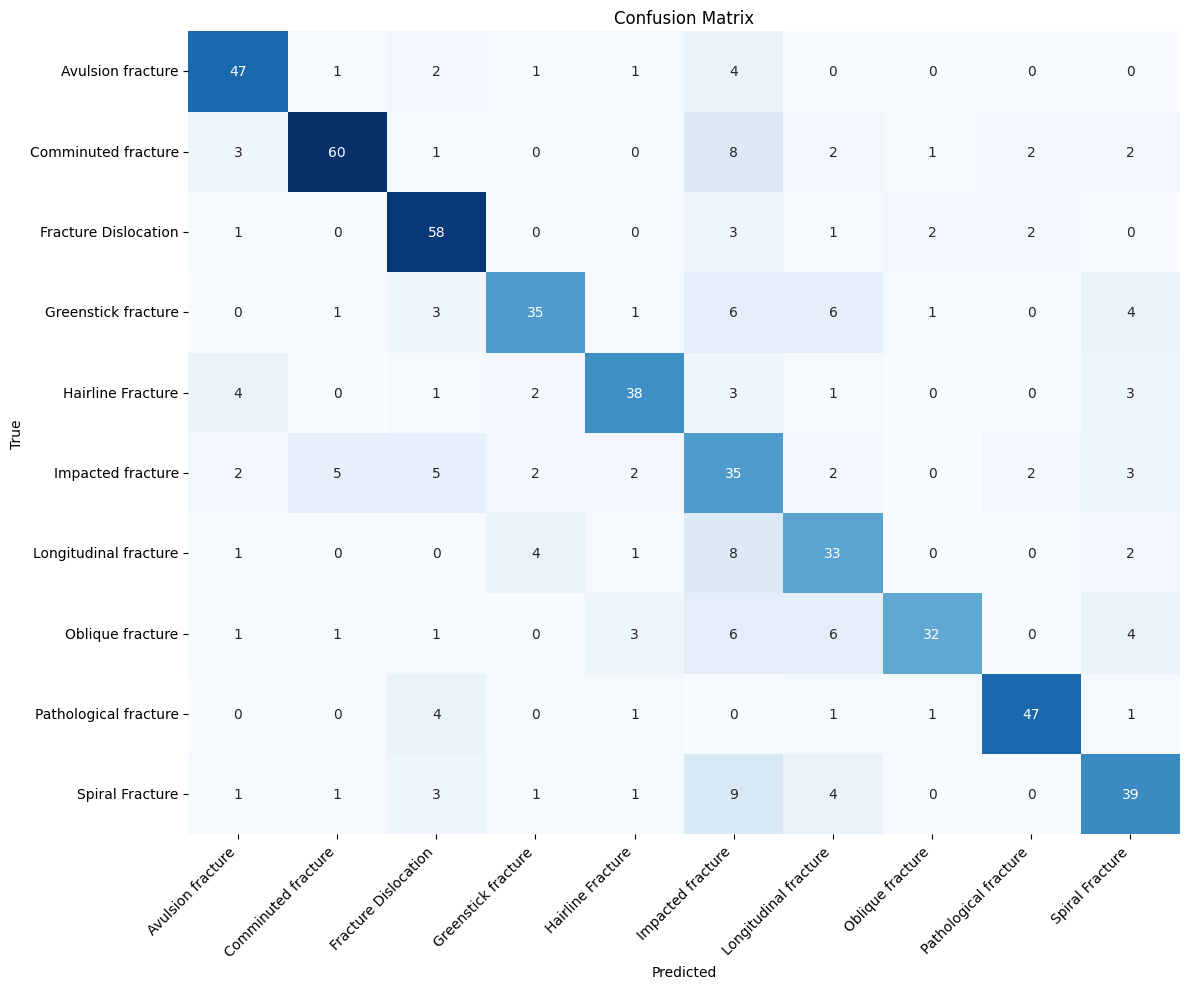

In [23]:
import os

from tensorflow.keras.preprocessing import image

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns



# Fungsi untuk memuat gambar dan melakukan preprocessing

def load_and_preprocess_image(img_path, target_size=(299, 299)):

    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array /= 255.0

    return img_array



# Fungsi untuk memproses semua gambar dalam folder dan menghitung evaluasi

def evaluate_model_on_folder(folder_path, class_names, target_size=(299, 299)):

    y_true = []

    y_pred = []



    # Disable TensorFlow logs

    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



    for class_idx, class_name in enumerate(class_names):

        class_folder = os.path.join(folder_path, class_name)

        if os.path.isdir(class_folder):

            img_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]



            for img_file in img_files:

                img_path = os.path.join(class_folder, img_file)

                img_array = load_and_preprocess_image(img_path, target_size)



                # Prediksi menggunakan model tanpa log per gambar

                predictions = model.predict(img_array, verbose=0)

                predicted_class = np.argmax(predictions, axis=1)



                y_true.append(class_idx)

                y_pred.append(predicted_class[0])



    # Menghitung akurasi

    accuracy = accuracy_score(y_true, y_pred)

    print(f'Accuracy: {accuracy * 100:.2f}%')



    # Mencetak laporan klasifikasi

    print("\nClassification Report:")

    report = classification_report(y_true, y_pred, target_names=class_names)

    print(report)



    # Menghitung dan menampilkan confusion matrix

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    plt.figure(figsize=(12, 10))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,

                cbar=False, annot_kws={"size": 10})

    plt.xlabel('Predicted')

    plt.ylabel('True')

    plt.title('Confusion Matrix')

    plt.xticks(rotation=45, ha='right')

    plt.yticks(rotation=0)

    plt.tight_layout()

    plt.show()



# Tentukan path folder yang berisi subfolder kelas

folder_path = "/kaggle/input/testdl/test"



# Daftar nama kelas

class_names = ["Avulsion fracture", "Comminuted fracture", "Fracture Dislocation", "Greenstick fracture",

               "Hairline Fracture", "Impacted fracture", "Longitudinal fracture", "Oblique fracture",

               "Pathological fracture", "Spiral Fracture"]



# Panggil fungsi untuk mengevaluasi model pada folder test

evaluate_model_on_folder(folder_path, class_names)

## Save Model

In [16]:
# Simpan model
model.save('Bone_Fracture_InceptionV3.h5')